# 다음에 볼 영화 예측하기
## 프로젝트 - Movielens 영화 SBR

In [1]:
import os
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
# 추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 입니다.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### Session Length

In [4]:
# 각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [6]:
user_length.min(), user_length.max()

(20, 2314)

In [7]:
user_length.quantile(0.999)

1343.181000000005

In [8]:
long_user = user_length[user_length==200].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
406366,2438,908,3,974222921
406379,2438,2294,3,974222921
406412,2438,3812,5,974222921
406418,2438,3835,2,974222921
406427,2438,1186,4,974222921
...,...,...,...,...
406356,2438,3948,4,979792076
406461,2438,2502,4,981262001
406372,2438,1466,4,981322989
406413,2438,1131,5,987127691


In [9]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

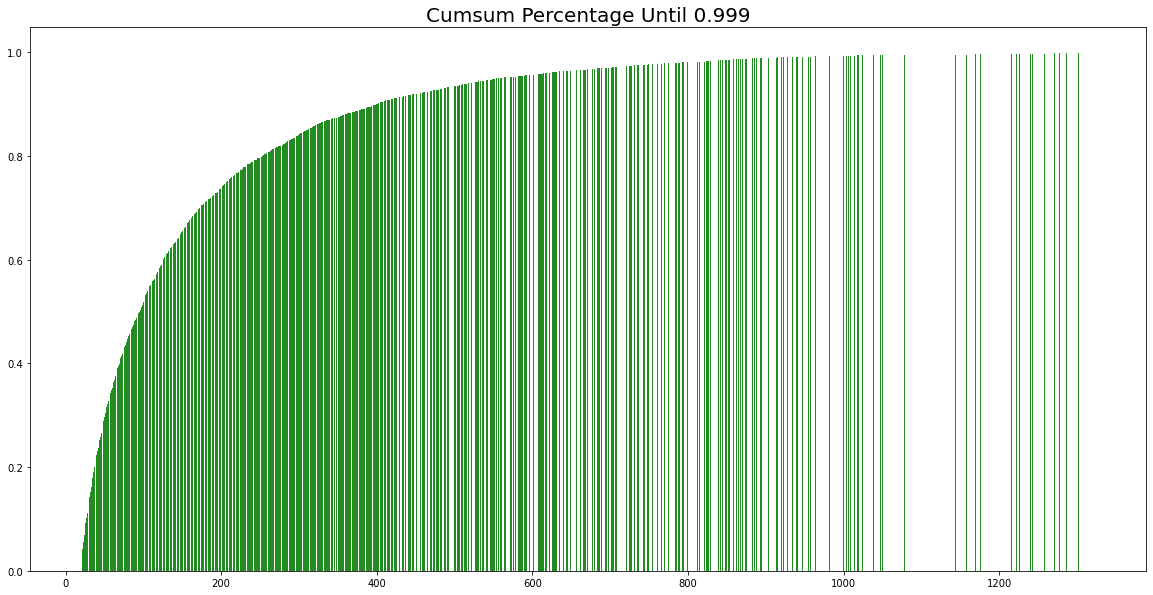

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='forestgreen')
#plt.xticks(length_percent_cumsum_999.index)
#plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [11]:
long_rating = user_length[user_length==2314].index[0]
data[data['UserId']==long_rating]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


### Session Time

In [12]:
import datetime

In [13]:
# 우선 Time 컬럼이 보기가 힘드니 Date 로 바꿔서 보겠습니다

dt = datetime.datetime.strptime('1970-01-01', '%Y-%m-%d')
tmp = data['Time']
datatime = []
for i in tmp:
    date = dt + datetime.timedelta(seconds= i)
    tmp = date.strftime('%Y-%m-%d')
    datatime.append(tmp)

data['Date'] = datatime

In [14]:
data

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


In [15]:
oldest, latest = data['Date'].min(), data['Date'].max()
print(oldest) 
print(latest)

2000-04-25
2003-02-28


In [16]:
type(latest)

str

In [17]:
#영화 평점 분포 확인

mv_rate = data.groupby('Rating')['ItemId'].count()
mv_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: ItemId, dtype: int64

### Data Cleansing

In [25]:
# 앞서 말했듯이 너무 긴 세션을 가지고 있는 UserID를 제거해주겠습니다.
# 남긴 평점이 적다고 해서 선호하는 영화가 아니라는 건 아니기도 하고 적은 평점을 가진 영화가 대부분이기도 하기때문에 
# 다른 cleansing 처리는 하지 않습니다.

def cleanse_long_session(data: pd.DataFrame, longest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len < longest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_recursive(data: pd.DataFrame, longest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_long_session(data, longest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

In [24]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


### Train/ Valid/ Test split

In [26]:
data['Date'].max()

'2003-02-28'

In [27]:
data.groupby('UserId')['Date'].max()

UserId
1       2001-01-06
2       2000-12-31
3       2000-12-31
4       2000-12-31
5       2000-12-31
           ...    
6036    2000-04-26
6037    2000-04-27
6038    2000-04-26
6039    2000-04-26
6040    2001-08-20
Name: Date, Length: 6040, dtype: object

In [28]:
from dateutil.relativedelta import relativedelta
from datetime import datetime

def split_by_month(data: pd.DataFrame, n_months: int):
    final_time = pd.to_datetime(data['Date'].max())
    #print(final_time)
    session_last_time = data.groupby('UserId')['Date'].max()
    tmp = final_time - relativedelta(months = n_months)   # 맨 끝 날짜에서 n개월을 뺍니다
    tmpdate = tmp.strftime('%Y-%m-%d') # string 타입으로 변환
    #print(tmp)
    session_in_train = session_last_time[session_last_time < tmpdate].index
    session_in_test = session_last_time[session_last_time >= tmpdate].index
    
    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [29]:
train, test = split_by_month(data, n_months=14)
train, valid = split_by_month(train, n_months=8)

In [30]:
train

,UserId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31
22,1,1270,5,978300055,2000-12-31
27,1,1721,4,978300055,2000-12-31
37,1,1022,5,978300055,2000-12-31
24,1,2340,3,978300103,2000-12-31
...,...,...,...,...,...
999798,6039,1148,4,956758002,2000-04-26
999764,6039,912,4,956758029,2000-04-26
999771,6039,922,5,956758029,2000-04-26
999815,6039,1204,5,956758029,2000-04-26


In [31]:
train['Date'].max()

'2001-04-25'

In [32]:
valid

,UserId,ItemId,Rating,Time,Date
2469,19,2527,3,978146700,2000-12-30
2298,19,593,5,978146713,2000-12-30
2432,19,527,3,978146727,2000-12-30
2457,19,1210,4,978146747,2000-12-30
2497,19,2115,3,978146747,2000-12-30
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10
999988,6040,1921,4,997454464,2001-08-10
1000172,6040,1784,3,997454464,2001-08-10
1000167,6040,161,3,997454486,2001-08-10


In [33]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Date"].min()}\n'
          f'\t Last Time : {data["Date"].max()}\n')

In [34]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 702680
	 Users: 5146
	 Items: 3410
	 First Time : 2000-04-25
	 Last Time : 2001-04-25

* valid Set Stats Info
	 Events: 77336
	 Users: 301
	 Items: 3205
	 First Time : 2000-04-25
	 Last Time : 2001-12-26

* test Set Stats Info
	 Events: 219577
	 Users: 593
	 Items: 3386
	 First Time : 2000-04-27
	 Last Time : 2003-02-28



In [35]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [36]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 미니 배치의 구성

In [37]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [38]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


### Session DataLoader

In [39]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [40]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Date,item_idx
31,1,3186,4,978300019,2000-12-31,0
22,1,1270,5,978300055,2000-12-31,1
27,1,1721,4,978300055,2000-12-31,2
37,1,1022,5,978300055,2000-12-31,3
24,1,2340,3,978300103,2000-12-31,4
36,1,1836,5,978300172,2000-12-31,5
3,1,3408,4,978300275,2000-12-31,6
7,1,2804,5,978300719,2000-12-31,7
47,1,1207,4,978300719,2000-12-31,8
0,1,1193,5,978300760,2000-12-31,9


In [41]:
iter_ex = iter(train_data_loader)

In [42]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### 모델 구성

In [43]:
# Evaluation Metric
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [44]:
# Model Architecture
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [45]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [47]:
class Args:
    def __init__(self, train, valid, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.valid = valid
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_sessions = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)

In [48]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3410)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    519300    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3410)               173910    
Total params: 693,210
Trainable params: 693,210
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Model Training
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.valid, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [51]:
train_model(model, args)

Evaluation:  21%|██        | 62/300 [01:04<04:06,  1.04s/it]


	 - Recall@20 epoch 1: 0.184035
	 - MRR@20    epoch 1: 0.047052



Evaluation:  21%|██        | 62/300 [01:00<03:52,  1.02it/s]


	 - Recall@20 epoch 2: 0.282069
	 - MRR@20    epoch 2: 0.078502



Evaluation:  21%|██        | 62/300 [00:58<03:45,  1.06it/s]


	 - Recall@20 epoch 3: 0.323778
	 - MRR@20    epoch 3: 0.093085



Evaluation:  21%|██        | 62/300 [00:57<03:40,  1.08it/s]


	 - Recall@20 epoch 4: 0.347845
	 - MRR@20    epoch 4: 0.105574



Evaluation:  21%|██        | 62/300 [00:56<03:38,  1.09it/s]


	 - Recall@20 epoch 5: 0.359753
	 - MRR@20    epoch 5: 0.112207



Evaluation:  21%|██        | 62/300 [00:56<03:35,  1.10it/s]


	 - Recall@20 epoch 6: 0.366116
	 - MRR@20    epoch 6: 0.117198



Evaluation:  21%|██        | 62/300 [00:56<03:34,  1.11it/s]


	 - Recall@20 epoch 7: 0.372354
	 - MRR@20    epoch 7: 0.120815



Evaluation:  21%|██        | 62/300 [00:56<03:35,  1.10it/s]


	 - Recall@20 epoch 8: 0.374685
	 - MRR@20    epoch 8: 0.122977



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.11it/s]


	 - Recall@20 epoch 9: 0.378087
	 - MRR@20    epoch 9: 0.124886



Evaluation:  21%|██        | 62/300 [00:55<03:34,  1.11it/s]


	 - Recall@20 epoch 10: 0.377583
	 - MRR@20    epoch 10: 0.125286



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.11it/s]


	 - Recall@20 epoch 11: 0.378843
	 - MRR@20    epoch 11: 0.126170



Evaluation:  21%|██        | 62/300 [00:55<03:34,  1.11it/s]


	 - Recall@20 epoch 12: 0.380481
	 - MRR@20    epoch 12: 0.126864



Evaluation:  21%|██        | 62/300 [00:56<03:35,  1.10it/s]


	 - Recall@20 epoch 13: 0.379725
	 - MRR@20    epoch 13: 0.128017



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.11it/s]


	 - Recall@20 epoch 14: 0.379977
	 - MRR@20    epoch 14: 0.127945



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.11it/s]


	 - Recall@20 epoch 15: 0.381174
	 - MRR@20    epoch 15: 0.127699



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.11it/s]


	 - Recall@20 epoch 16: 0.380796
	 - MRR@20    epoch 16: 0.128656



Evaluation:  21%|██        | 62/300 [00:56<03:35,  1.11it/s]


	 - Recall@20 epoch 17: 0.381174
	 - MRR@20    epoch 17: 0.128376



Evaluation:  21%|██        | 62/300 [00:57<03:39,  1.09it/s]


	 - Recall@20 epoch 18: 0.379851
	 - MRR@20    epoch 18: 0.128246



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.11it/s]


	 - Recall@20 epoch 19: 0.381111
	 - MRR@20    epoch 19: 0.129009



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.11it/s]


	 - Recall@20 epoch 20: 0.381993
	 - MRR@20    epoch 20: 0.128769



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 21: 0.381111
	 - MRR@20    epoch 21: 0.128492



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 22: 0.380292
	 - MRR@20    epoch 22: 0.128736



Evaluation:  21%|██        | 62/300 [00:55<03:34,  1.11it/s]


	 - Recall@20 epoch 23: 0.380355
	 - MRR@20    epoch 23: 0.128905



Evaluation:  21%|██        | 62/300 [00:55<03:31,  1.12it/s]


	 - Recall@20 epoch 24: 0.379851
	 - MRR@20    epoch 24: 0.128570



Evaluation:  21%|██        | 62/300 [00:55<03:31,  1.12it/s]


	 - Recall@20 epoch 25: 0.382245
	 - MRR@20    epoch 25: 0.129159



Evaluation:  21%|██        | 62/300 [00:55<03:31,  1.13it/s]


	 - Recall@20 epoch 26: 0.380859
	 - MRR@20    epoch 26: 0.128960



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 27: 0.382560
	 - MRR@20    epoch 27: 0.129355



Evaluation:  21%|██        | 62/300 [00:56<03:35,  1.10it/s]


	 - Recall@20 epoch 28: 0.381867
	 - MRR@20    epoch 28: 0.128984



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.12it/s]


	 - Recall@20 epoch 29: 0.382371
	 - MRR@20    epoch 29: 0.129530



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 30: 0.382119
	 - MRR@20    epoch 30: 0.129636



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.12it/s]


	 - Recall@20 epoch 31: 0.381615
	 - MRR@20    epoch 31: 0.129387



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 32: 0.381426
	 - MRR@20    epoch 32: 0.129435



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.12it/s]


	 - Recall@20 epoch 33: 0.381237
	 - MRR@20    epoch 33: 0.129434



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.12it/s]


	 - Recall@20 epoch 34: 0.381993
	 - MRR@20    epoch 34: 0.129469



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 35: 0.382812
	 - MRR@20    epoch 35: 0.129418



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 36: 0.381804
	 - MRR@20    epoch 36: 0.129822



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 37: 0.382749
	 - MRR@20    epoch 37: 0.129557



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 38: 0.381363
	 - MRR@20    epoch 38: 0.129430



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 39: 0.380859
	 - MRR@20    epoch 39: 0.128816



Evaluation:  21%|██        | 62/300 [00:55<03:31,  1.12it/s]


	 - Recall@20 epoch 40: 0.382497
	 - MRR@20    epoch 40: 0.129562



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 41: 0.380166
	 - MRR@20    epoch 41: 0.128903



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 42: 0.381300
	 - MRR@20    epoch 42: 0.128571



Evaluation:  21%|██        | 62/300 [00:55<03:34,  1.11it/s]


	 - Recall@20 epoch 43: 0.382876
	 - MRR@20    epoch 43: 0.128902



Evaluation:  21%|██        | 62/300 [00:55<03:34,  1.11it/s]


	 - Recall@20 epoch 44: 0.381174
	 - MRR@20    epoch 44: 0.128714



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 45: 0.381048
	 - MRR@20    epoch 45: 0.128674



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 46: 0.380859
	 - MRR@20    epoch 46: 0.128159



Evaluation:  21%|██        | 62/300 [00:55<03:33,  1.11it/s]


	 - Recall@20 epoch 47: 0.381678
	 - MRR@20    epoch 47: 0.129119



Evaluation:  21%|██        | 62/300 [00:55<03:32,  1.12it/s]


	 - Recall@20 epoch 48: 0.381300
	 - MRR@20    epoch 48: 0.128193



Evaluation:  21%|██        | 62/300 [00:55<03:31,  1.12it/s]


	 - Recall@20 epoch 49: 0.380859
	 - MRR@20    epoch 49: 0.128442



Evaluation:  21%|██        | 62/300 [00:55<03:31,  1.12it/s]

	 - Recall@20 epoch 50: 0.380607
	 - MRR@20    epoch 50: 0.127864



### 하이퍼파라미터 변경

In [52]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.4, lr=0.01, epochs=30, k=20)

In [53]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3410)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    519300    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3410)               173910    
Total params: 693,210
Trainable params: 693,210
Non-trainable params: 0
_________________________________________________________________


In [54]:
train_model(model, args)

Evaluation:  57%|█████▋    | 341/601 [02:54<02:13,  1.95it/s]


	 - Recall@20 epoch 1: 0.273712
	 - MRR@20    epoch 1: 0.073867



Evaluation:  57%|█████▋    | 341/601 [02:50<02:10,  2.00it/s]


	 - Recall@20 epoch 2: 0.285122
	 - MRR@20    epoch 2: 0.077665



Evaluation:  57%|█████▋    | 341/601 [02:52<02:11,  1.98it/s]


	 - Recall@20 epoch 3: 0.290300
	 - MRR@20    epoch 3: 0.080524



Evaluation:  57%|█████▋    | 341/601 [02:50<02:10,  2.00it/s]


	 - Recall@20 epoch 4: 0.291766
	 - MRR@20    epoch 4: 0.080695



Evaluation:  57%|█████▋    | 341/601 [02:50<02:10,  1.99it/s]


	 - Recall@20 epoch 5: 0.291537
	 - MRR@20    epoch 5: 0.081010



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 6: 0.295546
	 - MRR@20    epoch 6: 0.081058



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 7: 0.294469
	 - MRR@20    epoch 7: 0.080691



Evaluation:  57%|█████▋    | 341/601 [02:49<02:08,  2.02it/s]


	 - Recall@20 epoch 8: 0.294034
	 - MRR@20    epoch 8: 0.082526



Evaluation:  57%|█████▋    | 341/601 [02:49<02:08,  2.02it/s]


	 - Recall@20 epoch 9: 0.295180
	 - MRR@20    epoch 9: 0.082129



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 10: 0.294309
	 - MRR@20    epoch 10: 0.081759



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.02it/s]


	 - Recall@20 epoch 11: 0.295661
	 - MRR@20    epoch 11: 0.082348



Evaluation:  57%|█████▋    | 341/601 [02:49<02:08,  2.02it/s]


	 - Recall@20 epoch 12: 0.293736
	 - MRR@20    epoch 12: 0.081971



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 13: 0.294630
	 - MRR@20    epoch 13: 0.081424



Evaluation:  57%|█████▋    | 341/601 [02:49<02:08,  2.02it/s]


	 - Recall@20 epoch 14: 0.294607
	 - MRR@20    epoch 14: 0.082093



Evaluation:  57%|█████▋    | 341/601 [02:48<02:08,  2.02it/s]


	 - Recall@20 epoch 15: 0.296990
	 - MRR@20    epoch 15: 0.082382



Evaluation:  57%|█████▋    | 341/601 [02:50<02:09,  2.00it/s]


	 - Recall@20 epoch 16: 0.296508
	 - MRR@20    epoch 16: 0.081096



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 17: 0.296692
	 - MRR@20    epoch 17: 0.081631



Evaluation:  57%|█████▋    | 341/601 [02:50<02:09,  2.00it/s]


	 - Recall@20 epoch 18: 0.293530
	 - MRR@20    epoch 18: 0.081376



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 19: 0.297242
	 - MRR@20    epoch 19: 0.081710



Evaluation:  57%|█████▋    | 341/601 [02:50<02:10,  2.00it/s]


	 - Recall@20 epoch 20: 0.296050
	 - MRR@20    epoch 20: 0.081899



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 21: 0.293828
	 - MRR@20    epoch 21: 0.081177



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 22: 0.295936
	 - MRR@20    epoch 22: 0.082185



Evaluation:  57%|█████▋    | 341/601 [02:48<02:08,  2.02it/s]


	 - Recall@20 epoch 23: 0.296463
	 - MRR@20    epoch 23: 0.081926



Evaluation:  57%|█████▋    | 341/601 [02:50<02:09,  2.00it/s]


	 - Recall@20 epoch 24: 0.293232
	 - MRR@20    epoch 24: 0.081129



Evaluation:  57%|█████▋    | 341/601 [02:48<02:08,  2.03it/s]


	 - Recall@20 epoch 25: 0.294744
	 - MRR@20    epoch 25: 0.081933



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 26: 0.294905
	 - MRR@20    epoch 26: 0.081344



Evaluation:  57%|█████▋    | 341/601 [02:48<02:08,  2.02it/s]


	 - Recall@20 epoch 27: 0.292797
	 - MRR@20    epoch 27: 0.081400



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 28: 0.296256
	 - MRR@20    epoch 28: 0.081348



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]


	 - Recall@20 epoch 29: 0.292659
	 - MRR@20    epoch 29: 0.080886



Evaluation:  57%|█████▋    | 341/601 [02:49<02:09,  2.01it/s]

	 - Recall@20 epoch 30: 0.292133
	 - MRR@20    epoch 30: 0.079868



In [55]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  85%|████████▍ | 1447/1710 [12:23<02:15,  1.95it/s]

	 - Recall@20: 0.241151
	 - MRR@20: 0.065199



### 모델 구조 변경

In [56]:
from tensorflow.keras.losses import mse

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=mse, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [57]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [58]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3410)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    519300    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3410)               173910    
Total params: 693,210
Trainable params: 693,210
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_model(model, args)

Evaluation:  57%|█████▋    | 341/601 [03:12<02:26,  1.77it/s]


	 - Recall@20 epoch 1: 0.061332
	 - MRR@20    epoch 1: 0.012433



Evaluation:  57%|█████▋    | 341/601 [03:11<02:26,  1.78it/s]


	 - Recall@20 epoch 2: 0.062248
	 - MRR@20    epoch 2: 0.012614



Evaluation:  57%|█████▋    | 341/601 [03:12<02:26,  1.77it/s]


	 - Recall@20 epoch 3: 0.061859
	 - MRR@20    epoch 3: 0.012646



Evaluation:  57%|█████▋    | 341/601 [03:11<02:25,  1.78it/s]


	 - Recall@20 epoch 4: 0.061950
	 - MRR@20    epoch 4: 0.012633



Evaluation:  57%|█████▋    | 341/601 [03:12<02:26,  1.77it/s]


	 - Recall@20 epoch 5: 0.062019
	 - MRR@20    epoch 5: 0.012624



Evaluation:  57%|█████▋    | 341/601 [03:11<02:26,  1.78it/s]


	 - Recall@20 epoch 6: 0.062019
	 - MRR@20    epoch 6: 0.012624



Evaluation:  57%|█████▋    | 341/601 [03:13<02:27,  1.77it/s]


	 - Recall@20 epoch 7: 0.061859
	 - MRR@20    epoch 7: 0.012633



Evaluation:  57%|█████▋    | 341/601 [03:19<02:32,  1.71it/s]


	 - Recall@20 epoch 8: 0.061744
	 - MRR@20    epoch 8: 0.012619



Evaluation:  57%|█████▋    | 341/601 [03:13<02:27,  1.77it/s]


	 - Recall@20 epoch 9: 0.061492
	 - MRR@20    epoch 9: 0.012576



Evaluation:  57%|█████▋    | 341/601 [03:11<02:26,  1.78it/s]

	 - Recall@20 epoch 10: 0.061584
	 - MRR@20    epoch 10: 0.012575



In [60]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  85%|████████▍ | 1447/1710 [14:00<02:32,  1.72it/s]

	 - Recall@20: 0.041578
	 - MRR@20: 0.008012



### 회고

데이터톤이랑 같이 하다보니 정신이 없는상황이다. 그리고 데이터톤에 며칠동안 매달리다 보니 제대로 해보지 못하였다. 3번의 변경으로 시도해보였다. 모델은 기존의 노드에 나와있는걸 참고하였다. 하지만 3번다 그리 좋지 않은 모델로 판단된다. 에퐄과 로스를 변경해 보았지만 좋은 효과를 보지 못하였고 마지막엔 결과가 거의 달라ㅈ지 않는 상황이 나와서 당황스러웠다.